# Simulation of Particles in an Optofluidic Chip
I am a member of Holger Schmidt's research group, and we use and study optofluidic chips for a multitude of purposes. These multimode interference (MMI) optofluidic chips can be used to detect viruses and other nucleic acids as shown in this paper (https://www.pnas.org/content/112/42/12933.full). MMI optofluidic chips have input light of specific wavelengths which are coupled into the wide MMI waveguide where it creates bright anti-nodes on a fluidic channel as shown in the figure below. Each particle that passes through the fluidic channel is tagged with a fluorescent marker with a specified excitation wavelength. When the particle passes through an anti-node the fluorescent marker is excited to a higher energy level. When the energy level drops back to the ground state it emits a photon which is captured and routed to a photon detector. When the detector receives a photon it counts it and marks the time at which the photon was received to create a sparse dataset.

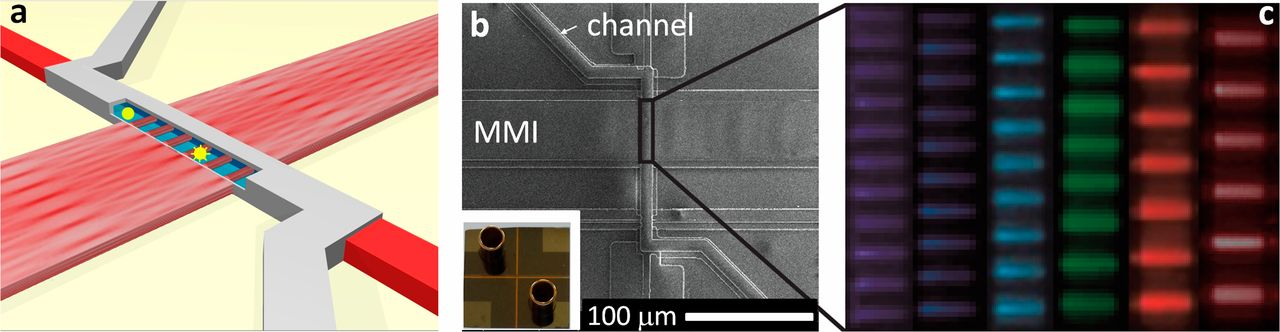

In the paper linked above, they use Signal-to-Noise Enhancement (SNR- mentioned in depth here: https://ieeexplore.ieee.org/document/7336520) to label the dataset and to count the total number of particles of each type that have passed through the chip. While they claim this method has 99.2% accuracy, this is unlikely. There are probably many events that have a near background noise intensity which would either be automatically discarded for being below some threshold value or even have just one peak that is below the threshold that would cause this method to return zero (null event).  
  
A machine learning algorithm that receives this dataset as an input may be able to read into the noise more efficiently than the SNR algorithm and be able to detect events that were not previously able to be detected. However, it will not be possible to create a 100% accurate dataset to train the machine learning algorithm from experimental data. The SNR algorithm mentioned in the linked papers exclusively uses experimental data which has the inaccuracies mentioned above.  

In order to create a dataset that is more accurate, I will simulate particles going through the optofluidic chip. The purpose of the simulation of these particles is to create a 100% accurate dataset for a ML algorithm to learn from. Success for this project means creating graphs that are visually as accurate as possible to the experimental data shown in the two linked papers, and to use equations that are as physically accurate as possible.

In [75]:
import numpy as np
import time
import math
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
np.set_printoptions(precision=None)
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

## Function Definitions
#### 1. N_gauss(t, N, L, A=0, sigma=0.2)
Not functionally useful, only for demonstration to show what an "ideal" photon emission graph would look like and visually compare it to the N\_erf function. The function is: $$ y= A*\sum_{n=0}^{N-1} \textrm{exp}\bigg(-\frac{(t-\frac{L}{N}(n+1/2))^2}{2\sigma^2}\bigg) $$
  
Inputs:  
N - the number of peaks for the function  
L - the length of the graph in time  
A - a scaling factor that sets the height of the peaks - if left blank it is auto normalized for $\int_{-\infty}^{\infty}\textrm{N_gauss}(t)dt$  
sigma - the sigma used in the gaussian function - by default $0.2*L/N$ looks pretty good so that's what I went with  
  
#### 2. N_erf(t, N, L, sigma=0.2)
This is the cumulative distribution function for N_gauss, the integral of a gaussian is an error function. This is used to generate a set of N\_gauss distributed time values. This function is not invertable, due to the erf functions being added together. The function is: $$ y = \frac{1}{2} + \frac{1}{2N}*\sum_{n=0}^{N-1} \textrm{erf}\bigg(\frac{t-\frac{L}{N}(n+1/2)}{\sqrt{2}\sigma}\bigg) $$
  
Inputs:  
N - the number of peaks for the function  
L - the length of the graph in time  
sigma - the sigma used in the gaussian function - by default $0.2*L/N$ looks pretty good so that's what I went with  
  
#### 3. log_norm_dist(v, v_peak, sigma=0.2) and log_norm_CDF(v, v_peak, sigma=0.2)
These are unused in the actual algorithm. Because it doesn't make sense for the particle velocity (v_particle) or the number of photons emitted per event (N_photons) to have a negative number associated with them, a gaussian will not work to randomize these values (it ranges from -$\infty$ to $\infty$). For this reason I went with a log normal distribution which is instead only valid and normalized from 0 to $\infty$. The distribution function is: $$ y = A*\textrm{exp}\Big(-\frac{\textrm{log}(v/\textrm{v_peak})}{2\sigma^2}\Big) \hspace{15mm} A=\Big(\sqrt{2\pi}\sigma*\textrm{exp}(\frac{1}{2}\sigma^2+\textrm{log}(\textrm{v_peak}))\Big)^{-1} $$  
The CDF function is: $$ r = \frac{1}{2} + \frac{1}{2}*\textrm{erf}\Bigg(\frac{1}{\sqrt{2}\sigma} \Big(\textrm{log}\big(\frac{v}{\textrm{v_peak}}\big)-\sigma^2\Big)\Bigg) $$
  
Inputs:  
v - the x-axis when graphing these functions    
v_peak - the highest point on the distribution function    
sigma - the sigma used in the gaussian function - the default value is 0.2, but this is fairly arbitrary
  
#### 4. log_norm_val_from_r(r, v_peak, sigma=0.2)
From the CDF, I was able to invert the normalized function so that simply a random value from 0 to 1 must be supplied in order to get the corresponding t value. This is the inversion method of generating a set of random numbers. This equation is: (and is the inverse of the CDF function above) $$ v = \textrm{v_peak}*\textrm{exp}\Big( \sqrt{2}\sigma\textrm{erf}^{-1}(2r-1) + \sigma^2 \Big) $$
  
Inputs:  
r - a random number between 0 and 1  
v_peak - the highest point on the distribution function  
sigma - the sigma used in the gaussian function - the default value is 0.2, but this is fairly arbitrary

In [99]:
#unused
def N_gauss(t, N, L, A=0, sigma=0.2):
    dt = L/N
    mu = dt/2
    sigma = sigma*dt
    if(A==0):
        A=1/(N*sigma*(2*np.pi)**0.5)
    y = 0
    for n in range(N):
        y += A*np.exp(-((t-mu)**2)/(2*sigma**2))
        mu += dt
    return y

#used for simulating particles
def N_erf(t, N, L, sigma=0.2): # N_gauss CDF
    try:
        len(t)
    except:
        t = [t]
    
    dt = L/N
    sigma = sigma*dt
    mu = [dt/2 + n*dt for n in range(N)]    
    A = 1/(2*N)

    y = [A*sp.erf(np.subtract(t, dt*(n+1/2) )/(sigma*2**(0.5))) for n in range(N)]
    y = np.add(0.5, np.sum(y,axis=0))
    return np.round(y,15)

def log_norm_dist(v, v_peak, sigma=0.2):
    A = 1/(np.exp((sigma**2+2*np.log(v_peak))/2)*sigma*(2*np.pi)**0.5)   
    return A*np.exp(-(np.log(v/v_peak)**2)/(2*sigma**2))
def log_norm_CDF(v, v_peak, sigma=0.2):
    return 0.5+0.5*sp.erf((np.log(v/v_peak)-sigma**2)/(sigma*2**0.5))

#used to randomize speeds and N_photons
def log_norm_val_from_r(r, v_peak, sigma=0.2):
    return v_peak*np.exp((sigma*2**0.5)*sp.erfinv(2*r-1)+sigma**2)

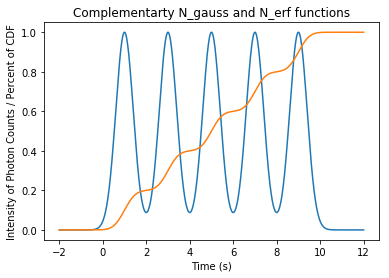

Text(0, 0.5, 'Likelyhood of a particular velocity / Percent of CDF')

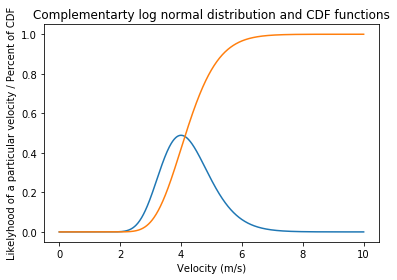

In [107]:
N = 5
L = 10
t_arr = np.linspace(-2,L+2,1000)
plt.plot(t_arr,N_gauss(t_arr,N,L,A=1))
plt.plot(t_arr,N_erf(t_arr,N,L))
plt.title("Complementarty N_gauss and N_erf functions")
plt.xlabel("Time (s)")
plt.ylabel("Intensity of Photon Counts / Percent of CDF")
plt.show()

v_arr = np.linspace(0.0001,10,1000)
v_peak = 4
plt.plot(v_arr, log_norm_dist(v_arr, v_peak))
plt.plot(v_arr, log_norm_CDF(v_arr, v_peak))
plt.title("Complementarty log normal distribution and CDF functions")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Likelyhood of a particular velocity / Percent of CDF")

## Generation Definitions  
#### get_interp(f, a, b)
This is used to invert N_erf() by using an interpolating function from scipy. It will return an interp function of the inverse of the function f that is given as an input.  
  
Inputs:
f - the function to inverse and interpolate
a,b - the lower and upper bound to interpolate over
  
#### generateEvents(N_events, N_peaks, avg_amplitude, avg_speed, runtime, N_background)
This is the main function for generating the dataset. The multiparticle handling section is to process the function inputs and check if they are a valid type, as well as to convert scalars to vectors if there are multiple types of particles being input. After this I start by creating the count_t and add all the background events. The background events are linearly spread across the entire runtime. I obtain the interp function for the specific N_peaks of this set of events for later use. Then t_event_start is randomly chosen across the entire runtime (linear spread). As explained previously, I use the log_norm_val_from_r function to randomize the particle velocities and N_photons based on the averages given in the input (avg_speed and avg_amplitude respectively). At this point I generate all of the photon events based on these values by plugging r_arr into the interp function as described in the comment in the function and add them onto the count_t array. Finally I generate the labels, where I use do a small histogram to find the max value of the function and the time of that peak and save all of these labels to a dictionary.  
  
Inputs:  
N_events - the number of events to be generated in this dataset (scalar or list)  
N_peaks - the number of peaks that the event will have - usually between 6 and 9 (scalar or list)  
avg_amplitude - the average amplitude of the highest peak of the function (scalar or list)  
avg_speed - the average speed of the particle, equivalent to MMI_width/avg_width (scalar or list)  
runtime - the length of time to generate the events  
N_background - the total number of background photon events  
sigma_v - (optional) the sigma value used to randomize the particle velocity with the log_norm_val_from_r function  
sigma_N - (optional) the sigma value used to randomize the number of photons generated in this event with the log_norm_val_from_r function  
MMI_width - (optional) the width of the MMI device - affects the width of events generated, the value used matches the one given in the paper mentioned in the introduction  
binsize - (optional) should be 1, as the inputs for time should be multiplied by a factor until the binsize is 1. If this value doesn't match the binsize used when graphing then the amplitudes graphed using scatter will not match up with the peaks and the graph will look really bad  

In [92]:
def get_interp(f, a, b):
    x_arr = np.linspace(a,b,100000)
    y_arr, idxs = np.unique(f(x_arr),return_index=True)
    interp = UnivariateSpline(y_arr,x_arr[idxs],s=0,k=3,ext=3)
    return interp

def generateEvents(N_events, N_peaks, avg_amplitude, avg_speed, runtime, N_background, sigma_v=0.2, sigma_N=0.2, MMI_width=0.0001, binsize=1):
    #multiparticle handling
    if isinstance(N_events, int):
        if isinstance(N_peaks,int) & isinstance(avg_amplitude,(int,float)) & isinstance(avg_speed,(int,float)):
            N_events, N_peaks, avg_amplitude, avg_speed = [N_events], [N_peaks], [avg_amplitude], [avg_speed]
        else:
            print("N_events must have the same shape as N_peaks, avg_amplitude, and avg_speed.")
            print("N_peaks, avg_amplitude, and avg_speed also must be of type int or float if they are scalar.")
            print(type(N_peaks))
            print(type(avg_amplitude))
            print(type(avg_speed))
            return False, False
    else:
        if isinstance(N_peaks,int):
            N_peaks = np.full(len(N_events),N_peaks)
        if isinstance(avg_amplitude,(int,float)):
            avg_amplitude = np.full(len(N_events),avg_amplitude)
        if isinstance(avg_speed,(int,float)):
            avg_speed = np.full(len(N_events),avg_speed)
    
    #actual algorithm
    label_dict = {"time":[],
                  "t_start":[],
                  "t_stop":[],
                  "amplitude":[],
                  "type":[],
                  "speed":[],
                  "N_photons":[]}
    count_t = np.multiply(runtime,np.random.random(N_background)) #start with background events
    for e in range(len(N_events)):
        interp = get_interp(lambda t: N_erf(t, N_peaks[e], 1), -1.2/N_peaks[e], 1+1.2/N_peaks[e])
        
        for i in range(N_events[e]):
            t_event_start = np.random.random()*runtime

            v_particle = log_norm_val_from_r(np.random.random(),avg_speed[e],sigma_v)
            N_photons = int(round(log_norm_val_from_r(np.random.random(),avg_amplitude[e]*17.08443,sigma_N))) #eventually this 500 will be replaced with avg_amp[e]
            
#             v_particle = avg_speed[e]
#             N_photons = avg_amplitude[e]
        
            r_arr = np.random.random(N_photons)
            #first interp(r_arr) to get time array, multiply by the length of time it actually took (MMI_width/v_particle),
            #then add the time offset (t_event_start) and add it to the array of all photon events
            count_t = np.append(count_t,np.add(np.multiply(interp(r_arr),MMI_width/v_particle),t_event_start))
            
            lBin = int(t_event_start/binsize)
            rBin = 1+int(MMI_width/(binsize*v_particle))
            hist, bins = np.histogram(count_t, bins=np.linspace(binsize*lBin,binsize*(lBin+rBin),rBin+1))
            
            label_dict["time"].append(bins[np.argmax(hist)]+0.5*binsize)
            label_dict["t_start"].append(t_event_start)
            label_dict["t_stop"].append(t_event_start+MMI_width/v_particle)
            label_dict["amplitude"].append(np.max(hist))
            label_dict["type"].append(e)
            label_dict["speed"].append(v_particle)
            label_dict["N_photons"].append(N_photons)
    return count_t, label_dict

## Full Data Graph
Now it is time to show off the actual simulation data! You can see the inital conditions I set in the first few lines. Then I obtain the sparse dataset and the labels associated with each event by using generateEvents(). Then I extract the time and amplitude of each event and histogram the sparse data. Finally I plot it and use scatter to put a dot on each peak for each type of particle in the data.  
  
One thing that looks a little odd here is that I've multiplied (and one division) a lot of things by 10000, and this isn't a randomly chosen value. The paper I mentioned in the introduction always had 0.1 ms bins, and there are 10000 0.1 ms bins in 1 second. The other issue is that histograms don't like bins to have non integer sizes. So, to make each bin size one, I am multiplying every time variable by a factor and then divide out that same factor at the end when I create the graph. The average speed is divided by that factor because the time is in the denominator (meters/second).  
  
Below is a graph of the experimental data that should be fairly similar to the graph that this function creates:
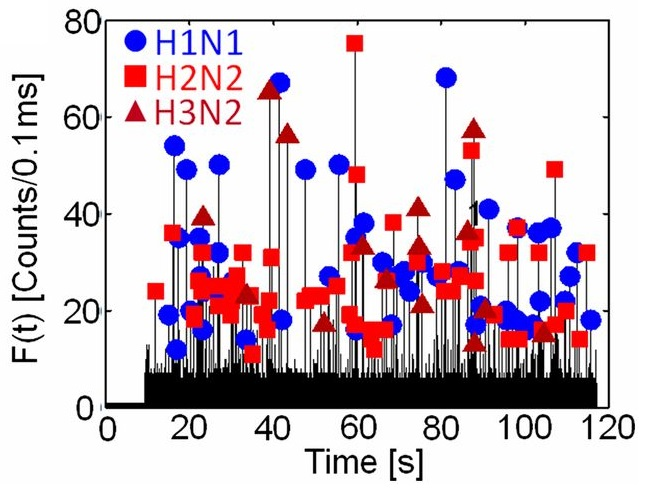

Text(0, 0.5, 'Intensity (counts/0.1ms)')

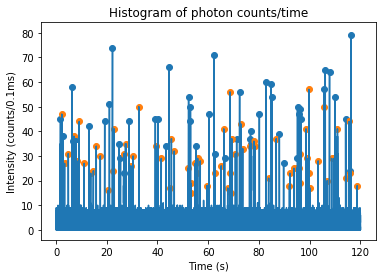

In [93]:
# Initial parameters
N_events = [50,70]
N_peaks = [9,6]
avg_amplitude = [35,20]

avg_speed = 0.025 #Unit: meters per second, this is assuming the MMI width of 100 um (0.0001m)
# avg_speed = np.array([0.05,0.025])

runtime = 120 #seconds
N_bgps = 20000
# N_bgps = 0
N_background = runtime*N_bgps

N_bins = runtime*10000

# Run the function
count_t, label_dict = generateEvents(N_events, N_peaks, avg_amplitude, avg_speed/10000, runtime*10000, N_background, sigma_v=0.4)

# Plot the histogram
hist = np.histogram(count_t, bins=np.linspace(0,N_bins,N_bins+1))[0]
bin_loc = np.linspace(runtime*0.5/N_bins, runtime*(1-0.5/N_bins), N_bins)
plt.plot(bin_loc, hist)

# Scatter the peaks
l_time = np.array(list(label_dict.values())[0])
l_amp = np.array(list(label_dict.values())[3])
for e in range(len(N_events)):
    idxs = np.where(np.array(list(label_dict.values())[4]) == e)[0]
    plt.scatter(np.divide(l_time[idxs],10000),l_amp[idxs])

plt.title("Histogram of photon counts/time")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (counts/0.1ms)")

## Individual Events
I can show an individual event simply by zooming in on the x axis. Other indexes of events can be accessed by changing the value of I_offset. It isn't in order, as their starting positions are not generated in order. The smaller that specific event's velocity is the less it will look like the example graph below. However, the example chosen here clearly has one of the largest amplitudes in the whole experimental dataset. The faster the particle is, the higher the amplitude will be, and also the nicer the resulting graph will be. Here is the experimental data's graph:  


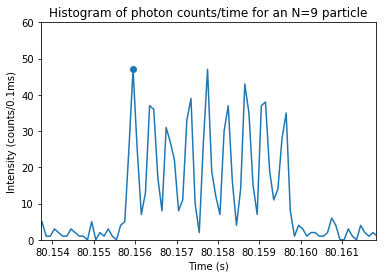

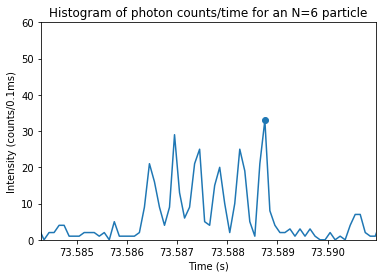

In [98]:
I_offset = 2 
plt.plot(bin_loc, hist)
plt.scatter(np.divide(l_time,10000),l_amp)
plt.title("Histogram of photon counts/time for an N=9 particle")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (counts/0.1ms)")
plt.xlim((list(label_dict.values())[1][I_offset]/10000-0.002,list(label_dict.values())[2][I_offset]/10000+0.002))
plt.ylim((0,60))
plt.ticklabel_format(useOffset=False)
plt.show()

I_offset = 60
plt.plot(bin_loc, hist)
plt.scatter(np.divide(l_time,10000),l_amp)
plt.title("Histogram of photon counts/time for an N=6 particle")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (counts/0.1ms)")
plt.xlim((list(label_dict.values())[1][I_offset]/10000-0.002,list(label_dict.values())[2][I_offset]/10000+0.002))
plt.ylim((0,60))
plt.ticklabel_format(useOffset=False)

Conclusion: I believe I have done a decent job of simulating this data. To be completely transparent, I had a meeting with the graduate student that I'm working with on this project and we discussed using a kind of parabolic distribution to generate the particle velocities for these events. The fluidic channels in these chips have laminar flow, which is modeled with a two dimensional parabola that depends on the height and width of the channel. However at the point that I found out this model would have been more realistic, I felt it was more important to try to complete the project more fully and switch out the probability function later. This is one aspect that I will work on in future iterations of the simulation, as well as the stretch goals of the last two phases in my initial report (mainly being able to generate a dataset from specific labels and some small extras).  
  
As for the accuracy of the simulation, the variation in the amplitudes between events is not as large as it is in the experimental data. This is something that may be improved simply by changing the velocity distribution function mentioned in the previous paragraph. The other thing that isn't ideal is the calculation of N_photons. The avg_N_photons I use in generation is literally $\textrm{avg_amplitude*17.08443}$, an equation I obtained by running a linear fit when I varied N_photons and then measured the average amplitude and graphed it. It did actually look very linear, and I'll put that code and figure in the next box. So it is only a rough approximation of what the amplitude should be. It's not perfect, but dealing with the randomness that is present in this simulation it is only a bit noticable. While I could have just had avg_N_photons as an input to the function, I decided I liked this approach better because it is more tangible to just tell the function directly how you want it to look instead of figuring out that 500 photons gives an average of around 30 counts/0.1 ms bin. I plan to create a better function for this in the future as well.  

[8.367, 14.139, 19.905, 25.152, 30.537, 36.109, 41.179, 46.323, 51.288, 56.613]


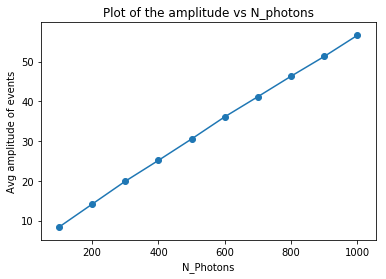

In [88]:
N_arr = np.linspace(100,1000,10)
amp_arr = []

for N in N_arr:
#     print(N)
    N_peaks = 8
    N_events = 1000
    avg_amplitude = int(N)
    avg_speed = 0.025
    runtime = 1000
    N_background = 0
    N_bins = runtime*10000
    count_t, label_dict = generateEvents(N_events, N_peaks, avg_amplitude, avg_speed/10000, runtime*10000, N_background)
    amp_arr.append(np.average(np.array(list(label_dict.values())[3])))   
plt.plot(N_arr,amp_arr)
plt.scatter(N_arr,amp_arr)
plt.title("Plot of the amplitude vs N_photons")
plt.xlabel("N_Photons")
plt.ylabel("Avg amplitude of events")
print(amp_arr)
# for i in range(len(N_arr)):
#     print(f"{N_arr[i]}    {amp_arr[i]}")

I believe this will be useful once I make the machine learning algorithm and include the few additions mentioned above. At it's current state it would be possible to use this data but I don't think it would produce a better algorithm than the SNR method. However, is useful to get a sense of how a simulated dataset would compare to the experimental data. The current state of this algorithm is an encouraging preliminary result. I've learned a lot about optimization of algorithms and how to compare the efficiency of different computational methods. I have also learned how to analyze and understand sets of random numbers. Finally, this project has greatly improved my understanding of the physical system behind the dataset that I will be doing research on over the summer.